# Smooth throughput in 2023

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : July 26th 2023
- update : July 26th 2023

** Kernel anaconda3_auxtel**

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

In [17]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.optimize import curve_fit
from scipy.odr import Model,ODR,RealData
from scipy import linalg

In [15]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/6cf2109gm_tmc.fits',
 'thermtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/6cf2109gm_tmc.fits',
 'thermtable': '/Volumes/Backup2020/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [6]:
path_calspec = os.path.join(os.getenv("PYSYN_CDBS"),"calspec")
   
dict_sedfilename = {'HD38666': "mucol_stis_005.fits", 
                    'HD42525': "eta1dor_stis_004.fits",
            'HD185975': "hd185975_stis_003.fits",
            'HD074000': "hd074000_stis_003.fits",
            'HD60753' : "hd60753_stis_003.fits",
            'HD111980': "hd111980_stis_003.fits",
            'HD37962':  "hd37962_stis_005.fits",
            'HD031128' : "hd031128_stis_005.fits",
            'HD14943' : "hd14943_stis_005.fits",
            'HD38949' : "hd38949_stis_005.fits",
            'HD60753' : "hd60753_stis_004.fits",
             'HD200654': "hd200654_stis_006.fits",  
             'HD115169': "hd115169_stis_003.fits",
             'HD142331': "hd142331_stis_004.fits", 
             'HD167060': "hd167060_stis_004.fits", 
            'HD146233': "18sco_stis_004.fits"       
              }   

## Config

In [3]:
!ls dataout

MLfit_bouguer_linearfit-2023-01-17-rebin1-HD38666.csv
MLfit_bouguer_linearfit-2023-01-17-rebin2-HD38666.csv
MLfit_bouguer_linearfit-2023-01-18-rebin1-HD38666.csv
MLfit_bouguer_linearfit-2023-01-18-rebin2-HD38666.csv
MLfit_bouguer_linearfit-2023-01-19-rebin1-HD42525.csv
MLfit_bouguer_linearfit-2023-01-19-rebin2-HD42525.csv


In [39]:
DATE = "2023-January-17-18"
FILTERTYPE = "empty~holo4_003"
SITE = "AUXTEL"
spectractormode = "psf2dffm"
FLAG_POLAR = False
target = "mucol"
filenames = [ "dataout/MLfit_bouguer_linearfit-2023-01-17-rebin1-HD38666.csv",  
              "dataout/MLfit_bouguer_linearfit-2023-01-17-rebin2-HD38666.csv",
             "dataout/MLfit_bouguer_linearfit-2023-01-18-rebin1-HD38666.csv",  
              "dataout/MLfit_bouguer_linearfit-2023-01-18-rebin2-HD38666.csv",]

tags = ["2023-01-17 (rebin1)", "2023-01-17 (rebin2)","2023-01-18 (rebin1)","2023-01-18 (rebin2)"]
outputfile_linearfit = "MLfit_bouguer_linearfit-HD38666-"

In [23]:
WLMINSEL = 350.
WLMAXSEL = 1025
WL= np.arange(WLMINSEL,WLMAXSEL)

## Initialisation

### Initialisation of SED

In [13]:
dict_f_sed = {}
dict_name_sed = {}

In [18]:
for targetid, sedfilename in dict_sedfilename.items():
    print(targetid, '->', sedfilename)
    s0=S.FileSpectrum(os.path.join(path_calspec,sedfilename))
    
    the_targetname = s0.fheader['TARGETID']
    
    sed_w=s0.wave/10
    sed_f=s0.flux*10
    sed_idx=np.where(np.logical_and(sed_w> WLMINSEL ,sed_w< WLMAXSEL))[0]
    sed_w=sed_w[sed_idx]
    sed_f=sed_f[sed_idx]
    
    # interpolation function
    f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")
    
    dict_name_sed[targetid] = the_targetname
    dict_f_sed[targetid] = f_sed 


HD38666 -> mucol_stis_005.fits
HD42525 -> eta1dor_stis_004.fits
HD185975 -> hd185975_stis_003.fits
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
HD074000 -> hd074000_stis_003.fits
HD60753 -> hd60753_stis_004.fits
HD111980 -> hd111980_stis_003.fits
HD37962 -> hd37962_stis_005.fits
Warning, 26 of 6260 bins contained negative fluxes; they have been set to zero.
HD031128 -> hd031128_stis_005.fits
Warning, 1 of 6256 bins contained negative fluxes; they have been set to zero.
HD14943 -> hd14943_stis_005.fits
Warning, 34 of 7206 bins contained negative fluxes; they have been set to zero.
HD38949 -> hd38949_stis_005.fits
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
HD200654 -> hd200654_stis_006.fits
HD115169 -> hd115169_stis_003.fits
Warning, 70 of 6817 bins contained negative fluxes; they have been set to zero.
HD142331 -> hd142331_stis_004.fits
Warning, 67 of 6816 bins contained negative fluxes; they have been set to zero.
H

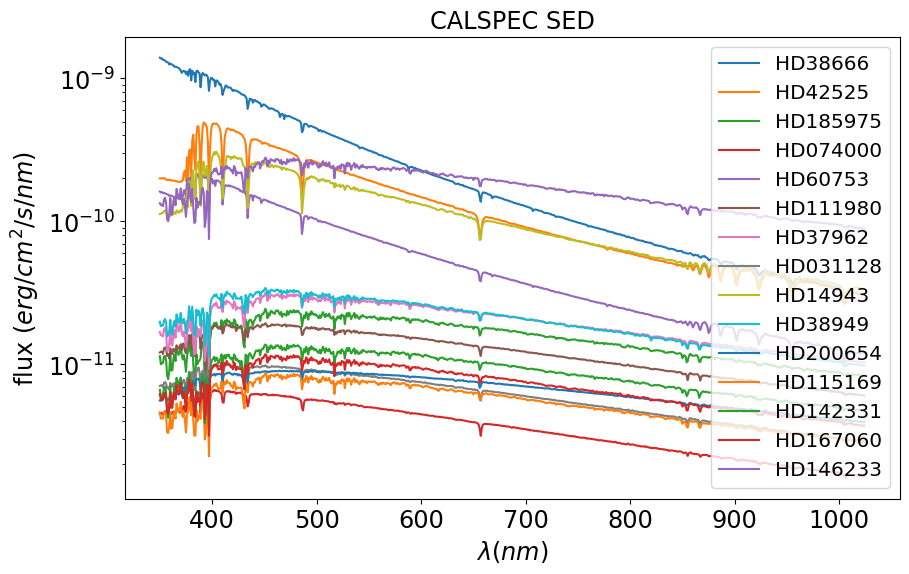

In [21]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():

    sed = f_sed(WL)
    sed_m=-2.5*np.log10(sed)
    
    label= f"{targetid}"
    ax.plot(WL,sed,label=label)
    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

## Read file

In [28]:
all_df = []

for filename in filenames:
    df = pd.read_csv(filename,index_col=0)
    all_df.append(df) 

In [33]:
df.head()

,wavelength,throu,errthrou,sedtoa,errsedtoa
0,355.000000,0.010126,0.001737,6.229383e-12,1.068782e-12
1,368.571429,0.014731,0.001812,1.640407e-11,2.017407e-12
2,382.142857,0.029273,0.002442,3.149967e-11,2.627249e-12
3,395.714286,0.048329,0.002778,4.794507e-11,2.756276e-12
4,409.285714,0.066795,0.002128,5.979069e-11,1.904754e-12


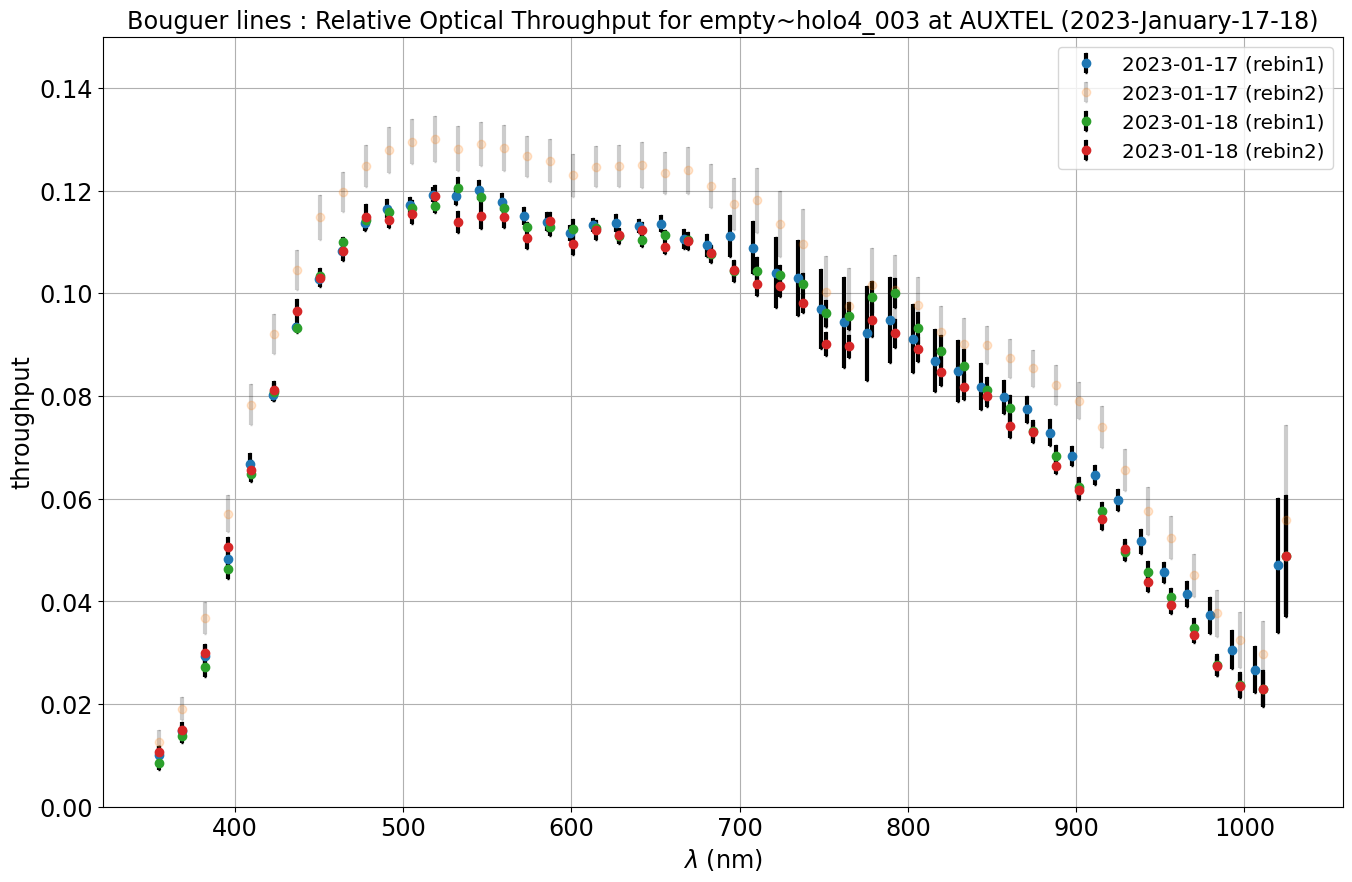

In [50]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)


for idx,df1 in enumerate(all_df):
    
    X1=df1["wavelength"].values
    Y1=df1["throu"].values
    EY1= df1["errthrou"].values


    if idx==1:
        ax.errorbar(X1,Y1, yerr=EY1, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx],alpha=0.2)
    else:
        ax.errorbar(X1,Y1, yerr=EY1, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx])

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Relative Optical Throughput for {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(0,0.15)
ax.legend()
        

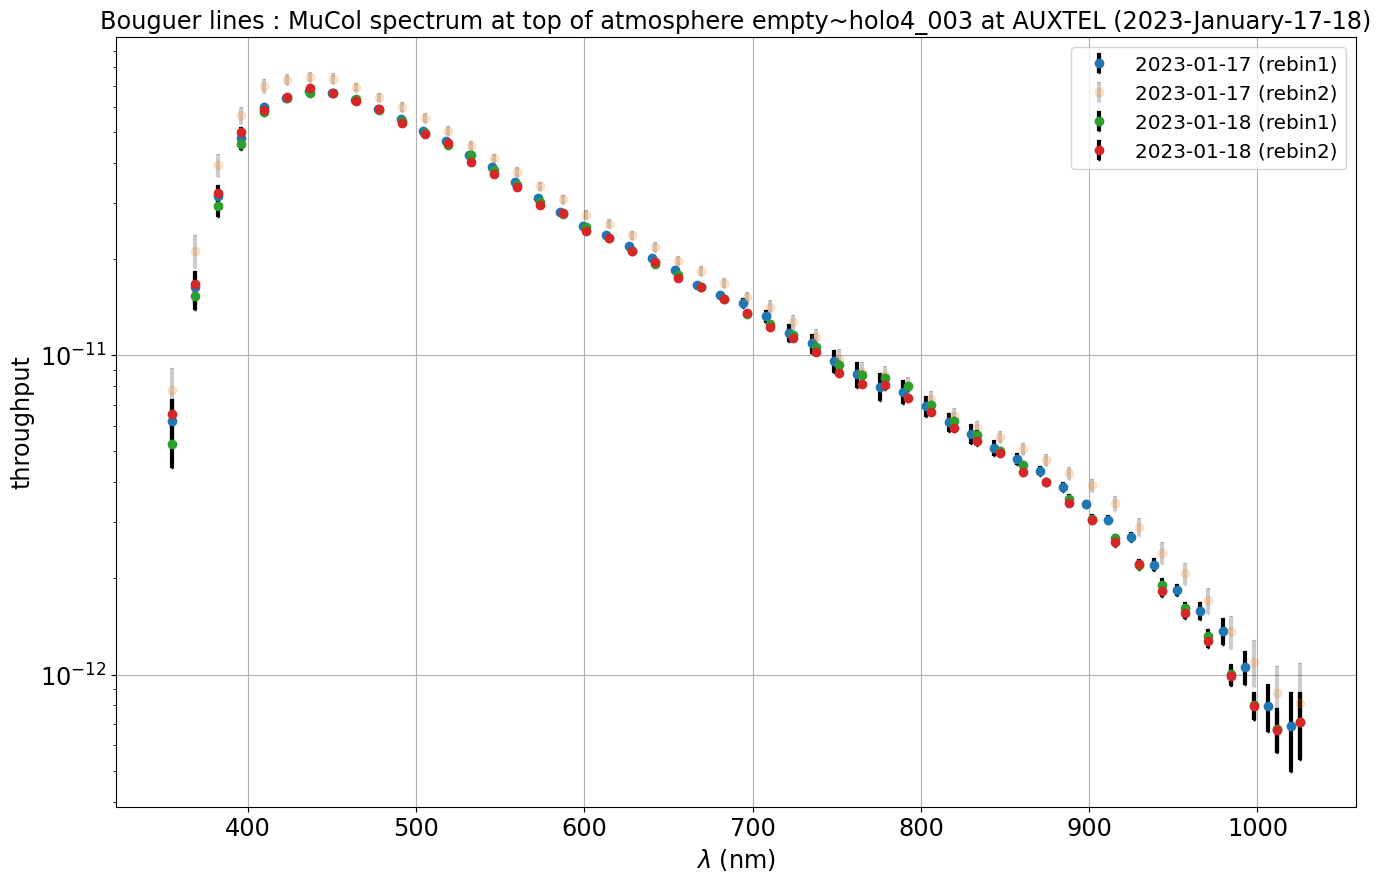

In [52]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)


for idx,df1 in enumerate(all_df):
    
    X1=df1["wavelength"].values
    Y1=df1["sedtoa"].values
    EY1= df1["errsedtoa"].values


    if idx==1:
        ax.errorbar(X1,Y1, yerr=EY1, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx],alpha=0.2)
    else:
        ax.errorbar(X1,Y1, yerr=EY1, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx])

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : MuCol spectrum at top of atmosphere {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
#ax.set_ylim(0,0.2)
ax.set_yscale('log')


In [43]:
f_sed =  dict_f_sed['HD38666']

(0.0, 0.15)

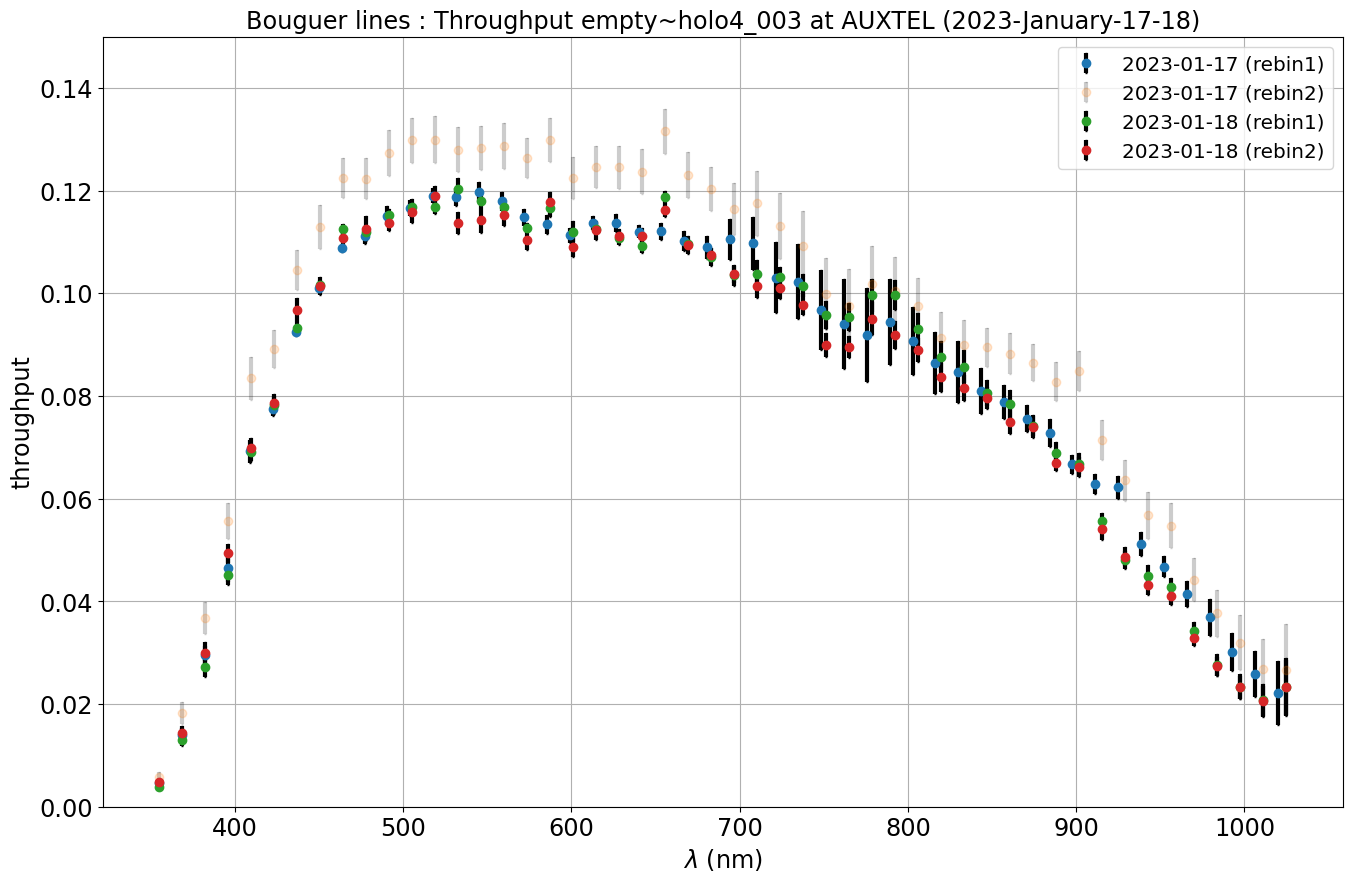

In [49]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)


for idx,df1 in enumerate(all_df):
    
    X1=df1["wavelength"].values
    Y1=df1["sedtoa"].values
    EY1= df1["errsedtoa"].values
    
    Y2 = Y1/f_sed(X1)
    EY2 = EY1/f_sed(X1)

    if idx==1:
        ax.errorbar(X1,Y2, yerr=EY2, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx],alpha=0.2)
    else:
        ax.errorbar(X1,Y2, yerr=EY2, xerr=None, fmt='o',ecolor="k", elinewidth=3, capsize=1,label=tags[idx])

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Throughput {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(0,0.15)


In [ ]:
assert False

# Insert First element

In [13]:
X = np.insert(X,0,360.)
Y = np.insert(Y,0,0.01)
EY = np.insert(EY,0,EY.max())

X = np.insert(X,0,350.)
Y = np.insert(Y,0,0.)
EY = np.insert(EY,0,EY.max())

Text(0.5, 1.0, 'Bouguer lines : Relative Optical Throughput for empty~holo4_003 at AUXTEL (2023-January)')

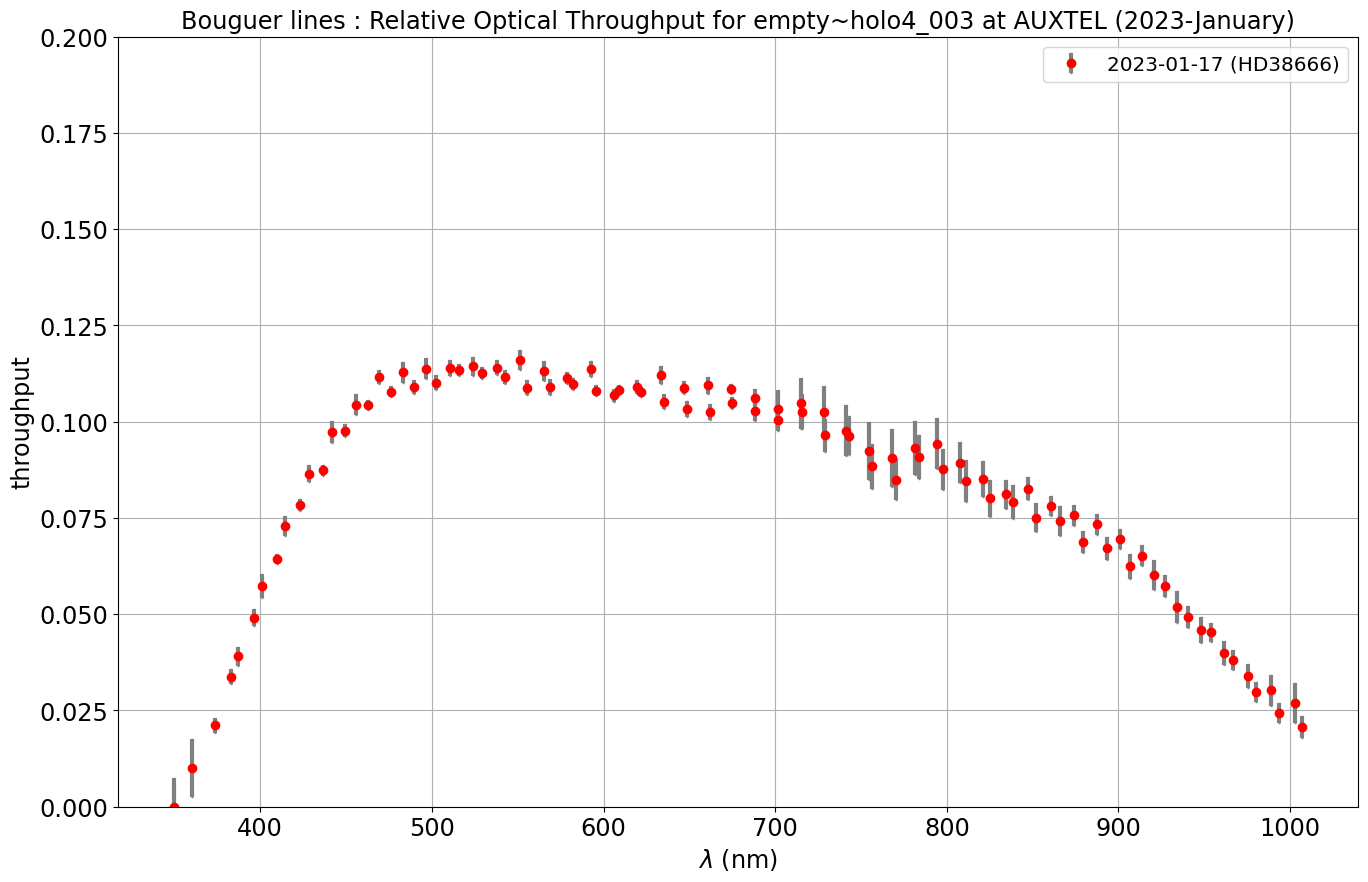

In [14]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="grey", elinewidth=3, capsize=1,label="2023-01-17 (HD38666)")
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(0,0.2)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Relative Optical Throughput for {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)

# Insert Last Element

In [15]:
X = np.append(X,1025)
Y = np.append(Y,0.01)
EY = np.append(EY,EY.max())


X = np.append(X,1050)
Y = np.append(Y,0.)
EY = np.append(EY,EY.max())

Text(0.5, 1.0, 'Bouguer lines : Relative Optical Throughput for empty~holo4_003 at AUXTEL (2023-January)')

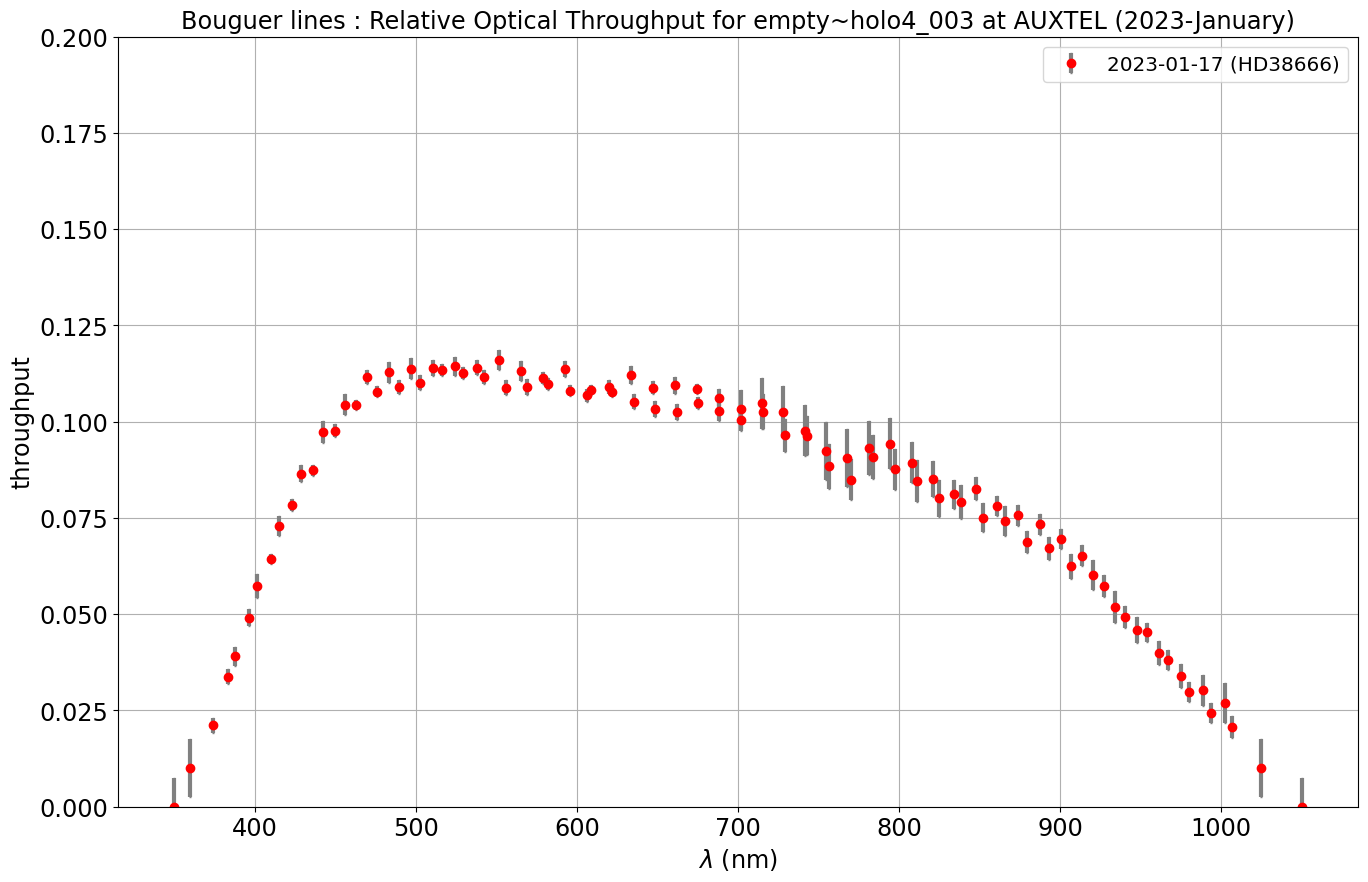

In [16]:
fig = plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)

ax.errorbar(X,Y, yerr=EY, xerr=None, fmt='o',color="r",ecolor="grey", elinewidth=3, capsize=1,label="2023-01-17 (HD38666)")
ax.grid()
ax.legend()
#ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(0,0.2)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Relative Optical Throughput for {FILTERTYPE} at {SITE} ({DATE})"
ax.set_title(title)

# Fit a gaussian process

In [17]:
dfout = pd.DataFrame()
dfout["wavelength"]=X
dfout["throu"]=Y
dfout["errthrou"]=EY

In [18]:
!ls dataout/

MLfit_bouguer_linearfit-20220630-empty~holo4_003-config_DECONVOLUTION_PSF2DFFM_out.csv
MLfit_bouguer_linearfit-2023-01-17-HD38666.csv
MLfit_bouguer_linearfit-2023-01-18-HD38666.csv
MLfit_bouguer_linearfit-2023-January-mucol.csv
MLfit_bouguer_linearfit-20230509-empty~holo4_003-config_DECONVOLUTION_PSF2DFFM_30nm_out.csv
MLfit_bouguer_linearfit-20230509-empty~holo4_003-config_DECONVOLUTION_PSF2DFFM_out.csv
MLfit_bouguer_linearfit-20230510-empty~holo4_003-config_DECONVOLUTION_PSF2DFFM_out.csv
MLfit_bouguer_linearfit-20230511-empty~holo4_003-config_DECONVOLUTION_PSF2DFFM_out.csv


In [19]:
outputroot = outputfile_linearfit.split('-')[0]
if FLAG_POLAR:
    outputfile_linearfit=outputroot+f"-{DATE}-polar.csv"
else:
    outputfile_linearfit=outputroot+f"-{DATE}-{target}.csv" 

In [20]:
# Save CSV file
dfout.to_csv(outputfile_linearfit) 

# Fit gaussian

https://www.astroml.org/book_figures/chapter8/fig_gp_example.html


In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [22]:
kernel = kernels.RBF(0.5, (1, 50.0))
gp = GaussianProcessRegressor(kernel=kernel, alpha=(EY) ** 2, random_state=0)

In [23]:
gp.fit(X[:, None], Y)

x = np.arange(350.,1050.,1.)

f, f_err = gp.predict(x[:, None], return_std=True)

/Users/sylvie/mambaforge/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [24]:
# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gp.kernel_.theta)

best-fit theta = [3.91202301]


Text(0.5, 1.0, 'Bouguer lines : Relative Optical Throughput for empty~holo4_003 at AUXTEL (2023-January)')

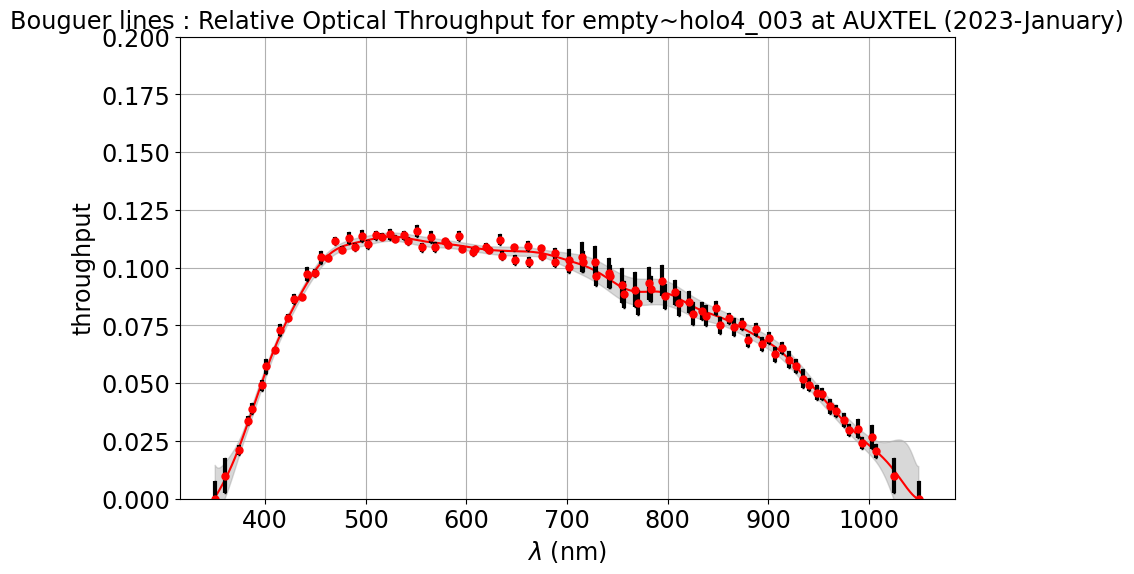

In [32]:
# third: plot a more constrained function with errors
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(x, f, '-', color='red')
ax.fill_between(x, f - 2 * f_err, f + 2 * f_err, color='gray', alpha=0.3)
ax.errorbar(X, Y, EY, fmt='o',color="r",ecolor="k", elinewidth=3, capsize=1, ms=5)
ax.set_ylim(0.,.2)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Bouguer lines : Relative Optical Throughput for {FILTERTYPE} at {SITE} ({DATE})"
ax.grid()
ax.set_title(title)

In [26]:
dfout = pd.DataFrame()
dfout["wavelength"]=x
dfout["throu"]=f
dfout["errthrou"]= f_err*2

In [27]:
outputroot = outputfile_linearfit.split('-')[0]
if FLAG_POLAR:
    outputfile_linearfit=outputroot+"smoothGP"+f"-{DATE}-polar.csv"
else:
    outputfile_linearfit=outputroot+"smoothGP"+f"-{DATE}-{target}.csv" 

In [28]:
# Save CSV file
dfout.to_csv(outputfile_linearfit) 